<center>
    <h1>Tema 4: Redes Neuronales</h1>
    <h1>Aprendizaje por Transferencia</h1>
    <br>
    <h5>Prof. Wladimir Rodríguez</h5>
    <h5>wladimir@ula.ve</h5>
    <h5>Departamento de Computación</h5>
</center>

El aprendizaje por transferencia (*transfer learning*) es una técnica poderosa para entrenar redes neuronales profundas que le permite a uno tomar el conocimiento aprendido sobre un problema de aprendizaje profundo y aplicarlo a un problema de aprendizaje diferente pero similar.

El uso del aprendizaje por transferencia puede acelerar drásticamente la tasa de implementación de una aplicación que está diseñando, haciendo que tanto el entrenamiento como la implementación de su red neuronal profunda sean más simples y fáciles.

En esta clase repasaremos la teoría detrás del aprendizaje por transferencia y veremos cómo llevar a cabo un ejemplo de aprendizaje por transferencia en redes neuronales convolucionales (CNN) en PyTorch.

### ¿Qué es el aprendizaje por transferencia?

La idea detrás del aprendizaje por transferencia es tomar un modelo entrenado en una tarea y aplicarlo a una segunda tarea similar. El hecho de que un modelo ya haya entrenado algunos o todos los pesos para la segunda tarea significa que el modelo se puede implementar mucho más rápido. Esto permite una evaluación rápida del rendimiento y el ajuste del modelo, lo que permite una implementación más rápida en general. El aprendizaje por transferencia se está volviendo cada vez más popular en el campo del aprendizaje profundo, gracias a la gran cantidad de recursos computacionales y el tiempo necesario para entrenar modelos de aprendizaje profundo, además de conjuntos de datos grandes y complejos.

La principal limitación del aprendizaje por transferencia es que las características del modelo aprendidas durante la primera tarea son generales y no específicas de la primera. En la práctica, esto significa que los modelos entrenados para reconocer ciertos tipos de imágenes pueden reutilizarse para reconocer otras imágenes, siempre que las características generales de las imágenes sean similares.

### Modelos pre-entrenados para la clasificación de imágenes

Los modelos preentrenados son modelos de redes neuronales entrenados con conjuntos de datos de referencia muy grandes como `ImageNet`. El objetivo de `ImageNet` es clasificar con precisión las imágenes de entrada (más de 14 millones) en un conjunto de 1000 categorías de objetos comunes que los sistemas de visión artificial "verán" en la vida cotidiana. 

<img src='../figuras/ImageNet.png' />

La comunidad de aprendizaje profundo se ha beneficiado enormemente de estos modelos de código abierto. Además, los modelos preentrenados son un factor importante para los rápidos avances en la investigación de *Computer Vision*. Otros investigadores y profesionales pueden usar estos modelos de última generación en lugar de reinventar todo desde cero.

<img src='../figuras/Model_Timeline.png'/>

Estos son algunos de los modelos preentrenados mas utilizados:

- AlexNet
- VGG16
- Inception
- ResNet

### Arquitectura de AlexNet


<img src='../figuras/AlexNet.png'/>

### Arquitectura de VGG16


<img src='../figuras/vgg16.png'/>

### Arquitectura de InceptionV3


<img src='../figuras/inceptionV3.png'/>

### Arquitectura de ResNet


<img src='../figuras/ResNet.png'/>

## Ejemplo de Clasificación usando ResNet50 para clasificar Alien vs Predator

En este ejemplo usaremos una data de [kaggle](https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images) para clasificar las imagenes de `alien` y `predator`. Usando aprendizaje por transferencia con una red `ResNet50`.

### Importar las librerías

In [29]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

### Preparación de los datos

In [30]:
camino_datos = "../datos/alien_vs_predator_thumbnails/data/"

In [31]:
normalizar = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transformadores_datos = {
    'entrenamiento':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalizar
    ]),
    'validacion':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalizar
    ]),
}

conjunto_imagenes = {
    'entrenamiento': 
    datasets.ImageFolder(camino_datos + 'entrenamiento', transformadores_datos['entrenamiento']),
    'validacion': 
    datasets.ImageFolder(camino_datos + 'validacion', transformadores_datos['validacion'])
}

cargadores_datos = {
    'entrenamiento':
    torch.utils.data.DataLoader(conjunto_imagenes['entrenamiento'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),
    'validacion':
    torch.utils.data.DataLoader(conjunto_imagenes['validacion'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

### Definir dispositivo a utilizar

In [32]:
dispositivo = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dispositivo

device(type='cpu')

### Crear modelo basado en `ResNet50`

In [48]:
modelo = models.resnet50(pretrained=True).to(dispositivo)
    
for parametro in modelo.parameters():
    parametro.requires_grad = False   
    
modelo.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(dispositivo)

### Definir función de perdida y optimizador

In [52]:
perdida_fn = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.fc.parameters())

### Función para entrenar el modelo

In [53]:
def entrenar_modelo(modelo, perdida_fn, optimizador, epocas=5):
    for epoca in range(epocas):
        print(f'Epoca {epoca + 1}/{epocas}')
        print('-' * 10)

        for fase in ['entrenamiento', 'validacion']:
            if fase == 'entrenamiento':
                modelo.train()
            else:
                modelo.eval()

            perdida_actual = 0.0
            correctos_actual = 0

            for imagenes, etiquetas in cargadores_datos[fase]:
                imagenes = imagenes.to(dispositivo)
                etiquetas = etiquetas.to(dispositivo)

                salidas = modelo(imagenes)
                perdida = perdida_fn(salidas, etiquetas)

                if fase == 'entrenamiento':
                    optimizador.zero_grad()
                    perdida.backward()
                    optimizador.step()

                _, predicciones = torch.max(salidas, 1)
                perdida_actual += perdida.item() * imagenes.size(0)
                correctos_actual += torch.sum(predicciones == etiquetas.data)

            perdida_epoca = perdida_actual / len(conjunto_imagenes[fase])
            precision_epoca = correctos_actual.double() / len(conjunto_imagenes[fase])

            print(f'{fase} perdida: {perdida_epoca:.4f}, precisión: {precision_epoca:.4f}')
    return modelo

In [54]:
modelo_entrenado = entrenar_modelo(modelo, perdida_fn, optimizador, epocas=5)

Epoca 1/5
----------
entrenamiento perdida: 0.5705, precisión: 0.7075
validacion perdida: 0.3609, precisión: 0.8700
Epoca 2/5
----------
entrenamiento perdida: 0.3114, precisión: 0.8732
validacion perdida: 0.2835, precisión: 0.8950
Epoca 3/5
----------
entrenamiento perdida: 0.2232, precisión: 0.9164
validacion perdida: 0.2360, precisión: 0.9000
Epoca 4/5
----------
entrenamiento perdida: 0.2002, precisión: 0.9150
validacion perdida: 0.2160, precisión: 0.9050
Epoca 5/5
----------
entrenamiento perdida: 0.1731, precisión: 0.9280
validacion perdida: 0.2547, precisión: 0.8950


### Validar modelo con algunas imágenes

In [55]:
caminos_imagen_validacion = ["validacion/alien/11.jpg",
                        "validacion/alien/22.jpg",
                        "validacion/predator/33.jpg"]
lista_imagenes = [Image.open(camino_datos + camino_imagen) for camino_imagen in caminos_imagen_validacion]

In [56]:
lote_validacion = torch.stack([transformadores_datos['validacion'](imagen).to(dispositivo)
                                for imagen in lista_imagenes])

In [57]:
# La salida del modelo no son probabilidades
predicciones_logits_tensor = modelo(lote_validacion)
predicciones_logits_tensor

tensor([[ 2.0920, -3.1728],
        [ 0.9537, -1.6754],
        [-0.9135,  0.6446]], grad_fn=<AddmmBackward0>)

In [58]:
# convertir el modelo a probabilidades
predicciones_probabilidades = F.softmax(predicciones_logits_tensor, dim=1).cpu().data.numpy()
predicciones_probabilidades

array([[0.99485564, 0.00514429],
       [0.93270916, 0.06729087],
       [0.17392223, 0.82607776]], dtype=float32)

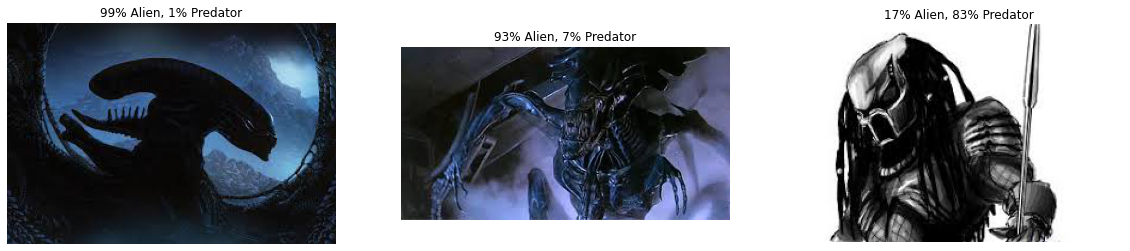

In [59]:
fig, axs = plt.subplots(1, len(lista_imagenes), figsize=(20, 5))
for i, imagen in enumerate(lista_imagenes):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f'{predicciones_probabilidades[i, 0] * 100:.0f}% Alien, {predicciones_probabilidades[i, 1] * 100:.0f}% Predator')
    ax.imshow(imagen)